In [33]:
from pathlib import Path
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
# Define base directory
DATA_DIR_RAW = Path("data/raw")
DATA_DIR_PROC = Path("data/processed")

# Define file paths
USERS   = DATA_DIR_RAW / "user.json"
REVIEWS = DATA_DIR_RAW / "review.json"
REVIEWS_CLEAN = DATA_DIR_RAW / "review_clean.ndjson"
BIZ     = DATA_DIR_RAW / "business.json"

# categories of restaurants
FOOD = DATA_DIR_RAW / "Food.txt"
RESTAURANTS = DATA_DIR_RAW / "restaurants.txt"


USERS_FILTERED = DATA_DIR_PROC / "yelp_filtered_user_ids.csv"

special_ids = set(pd.read_csv(USERS_FILTERED)["user_id"].astype(str))


In [2]:
len(special_ids)

892152

In [3]:
user = pd.read_json(USERS, lines=True, dtype={"user_id": str}, engine="pyarrow")
user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [4]:
# Filter out users with no friends or 'None'
mask_has_friends = (user['friends'] != 'None') & (user['friends'].notna())
active_users = user.loc[mask_has_friends].copy()


# separate the friends with a space
adj_lines = active_users['user_id'] + " " + active_users['friends'].str.replace(", ", " ")

# build a graph from the adjacency list
G = nx.parse_adjlist(adj_lines)

# create set of all valid users  
valid_user_ids = set(user['user_id'])

# keep only nodes that are in valid_user_ids and the graph
nodes_to_keep = valid_user_ids.intersection(G.nodes())
G = G.subgraph(nodes_to_keep)

# find the largest component of the graph
largest_cc_set = max(nx.connected_components(G), key=len)

final_df = user[user['user_id'].isin(largest_cc_set)].copy()

In [5]:
# save the final filtered user ids
final_df[['user_id']].to_csv(USERS_FILTERED, index=False)

In [6]:
review = pd.read_json(REVIEWS_CLEAN, lines=True, engine="pyarrow")
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [8]:
#usecols = ["business_id","categories","is_open", "stars", "review_count"]
#usecols = ["business_id","name","categories","city","state","is_open", "stars", "review_count"]
df = pd.read_json(BIZ, lines=True, dtype_backend="pyarrow")
print(len(df))

150346


In [9]:
df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


In [10]:
# drop nans 
df = df.dropna(subset=["categories"])
print(len(df))

150243


I was deciding whether to keep or delete the closed businesses from the dataset, I decided to keep them for now.

In [11]:
df[df['is_open'] == 0].describe()

,latitude,longitude,stars,review_count,is_open
count,30640.0,30640.0,30640.0,30640.0,30640.0
mean,36.865302,-88.936441,3.510117,37.776567,0.0
std,5.823943,14.697603,0.878553,71.158114,0.0
min,27.674867,-120.078856,1.0,5.0,0.0
25%,32.227404,-90.310474,3.0,8.0,0.0
50%,38.856831,-86.13085,3.5,15.0,0.0
75%,39.952972,-75.328024,4.0,37.0,0.0
max,53.64949,-74.664459,5.0,1781.0,0.0


In [12]:
#drop closed restaurants 
#df = df[(df["is_open"] == 1)]
#print(len(df))

In [13]:
# drop column is open 
df = df.drop(columns=["is_open"])

In [14]:
# unique categories 
len(df["categories"].unique())

83160

In [15]:
# Keep only the once that contain restaurants/food
is_foodish = df["categories"].str.contains(r"\b(?:Restaurants|Food)\b", case=False, na=False)
df = df[is_foodish]

In [16]:
# unique categories 
len(df["categories"].unique())

37846

In [17]:
# Load all the restaurant categories from the yelp dataset files
def get_categories(restaurants_file=RESTAURANTS, food_file=FOOD):
    cats = []
    with open(restaurants_file) as f:
        for line in f:
            s = line.strip()
            if s and s != "Restaurants":
                cats.append(s)
    with open(food_file) as f:
        for line in f:
            s = line.strip()
            if s and s != "Food":
                cats.append(s)
    return cats

In [18]:
# get all the categories in order
CATEGORIES_IN_ORDER = get_categories()

print("n cats:", len(CATEGORIES_IN_ORDER))
print(CATEGORIES_IN_ORDER[:12])

# set a seed 
random.seed(1337)


def simplify_random(categories_string):
    """
    Random version: instead of picking the first match,
    find ALL matches and pick one randomly
    """
    business_cats = {c.strip() for c in categories_string.split(",")}
    
    # Build a list of ALL categories that match
    matching_categories = []
    for cat in CATEGORIES_IN_ORDER:
        if cat in business_cats:
            matching_categories.append(cat)
    
    # If we found any matches, pick one at random
    if matching_categories:
        return random.choice(matching_categories)
    return "Other"

df["simple_category"] = df["categories"].apply(simplify_random)

n cats: 218
['Afghan', 'African', 'Senegalese', 'South African', 'American (New)', 'American (Traditional)', 'Arabian', 'Argentine', 'Armenian', 'Asian Fusion', 'Australian', 'Austrian']


In [19]:
def simple_experiment(df, n_runs=100, random_seed=1337):
    random.seed(random_seed)
    
    distributions = []
    for i in range(n_runs):
        simple_cat = df["categories"].apply(simplify_random)
        dist = simple_cat.value_counts(normalize=True)
        dist.name = f"trial_{i}"
        distributions.append(dist)
        
    dist_df = pd.concat(distributions, axis=1).fillna(0)  
    # per-category stats
    summary = pd.DataFrame({
        "mean": dist_df.mean(axis=1),
        "std":  dist_df.std(axis=1),
    })
    
    avg_std = summary["std"].mean()
    mean_ = summary["mean"].mean()

    print(f"Ran {n_runs} random trials.")
    print(f"Average change in category (mean std):   {avg_std:.4f}")
    print(f"Average category share (mean of means):        {mean_:.4f}")


simple_experiment(df, n_runs=100, random_seed=1337)

Ran 100 random trials.
Average change in category (mean std):   0.0001
Average category share (mean of means):        0.0049


In [20]:
df["categories"].head(10)

3     Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                             Brewpubs, Breweries, Food
5     Burgers, Fast Food, Sandwiches, Food, Ice Crea...
8     Pubs, Restaurants, Italian, Bars, American (Tr...
9     Ice Cream & Frozen Yogurt, Fast Food, Burgers,...
11           Vietnamese, Food, Restaurants, Food Trucks
12    American (Traditional), Restaurants, Diners, B...
14          Food, Delis, Italian, Bakeries, Restaurants
15                    Sushi Bars, Restaurants, Japanese
19                                  Korean, Restaurants
Name: categories, dtype: string[pyarrow]

In [21]:
len(df["simple_category"].unique())

201

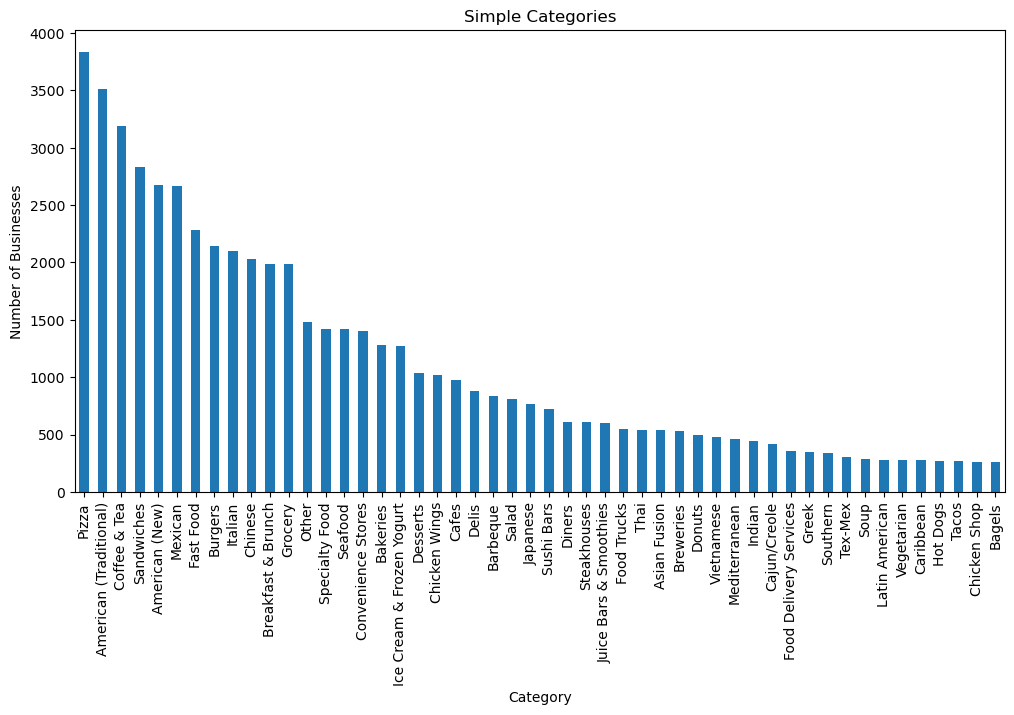

In [22]:
category_counts = df["simple_category"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,6))
category_counts.head(50).plot(kind='bar')
plt.title("Simple Categories")
plt.xlabel("Category")
plt.ylabel("Number of Businesses")
plt.show()

In [23]:
vc = df["simple_category"].value_counts()
print("Share of the first top 20 companies:", vc.head(20).sum()/vc.sum())


Share of the first top 20 companies: 0.6431843506252322


#### RECODING TO INTEGER VALUES FOR CATEGORIES 

In [24]:
# save the proeccesd dataframe into a parquet file
df.to_parquet(DATA_DIR_PROC / "business_processed.parquet", index=False)

In [25]:
# load the processed dataframe
biz_proc = pd.read_parquet(DATA_DIR_PROC / "business_processed.parquet")[["business_id", "simple_category"]]

# save the business_id column as string[pyarrow] for efficient storage
biz_proc["business_id"]  = biz_proc["business_id"].astype("string[pyarrow]")

print("Length of biz:", len(biz_proc))


Length of biz: 64616


In [26]:
# Create category encoding 
cats = biz_proc["simple_category"].drop_duplicates().sort_values().to_list()
cat_to_id = {cat: idx for idx, cat in enumerate(cats)}

# Save category vocabulary
id2cat = pd.DataFrame({"cat_id": range(len(cats)), "simple_category": cats})
id2cat.to_parquet(DATA_DIR_PROC / "cat_vocab.parquet", index=False)

# Create reverse mapping for later use
id2cat_map = {i: c for i, c in enumerate(cats)}

In [28]:
# apply the encoding and create business mapping 
# Apply encoding and create business mapping
biz_proc["cat_id"] = biz_proc["simple_category"].map(cat_to_id).astype("int32[pyarrow]")
biz_map = biz_proc[["business_id", "simple_category", "cat_id"]].drop_duplicates("business_id").set_index("business_id")
print(f"Created mappings for {len(cats)} categories")

Created mappings for 201 categories


In [29]:
# process the reviews in chunks 

RV_PARTS = DATA_DIR_PROC / "reviews_cat_parts"
RV_PARTS.mkdir(parents=True, exist_ok=True)

usecols = ["user_id", "business_id", "stars"]
part = 0


In [32]:
for chunk in pd.read_json(REVIEWS_CLEAN, lines=True, dtype_backend="pyarrow", chunksize=500_000):
    r = chunk[usecols].dropna(subset=["user_id", "business_id", "stars"]).copy()
    r["user_id"] = r["user_id"].astype("string[pyarrow]")
    r["business_id"] = r["business_id"].astype("string[pyarrow]")
    
    r = r[r["user_id"].isin(final_df["user_id"])]
    if r.empty:
        continue
    
    # Split by stars and join with business mapping
    high = r[r["stars"] >= 4.0]
    low = r[r["stars"] <= 2.0]
    
    if len(high):
        high = high.join(biz_map, on="business_id", how="inner")
        if len(high):
            high.to_parquet(RV_PARTS / f"high_{part:05d}.parquet", index=False)
    
    if len(low):
        low = low.join(biz_map, on="business_id", how="inner")
        if len(low):
            low.to_parquet(RV_PARTS / f"low_{part:05d}.parquet", index=False)
    
    part += 1

print("Wrote parts:", part)


Wrote parts: 14


In [34]:
liked_ids = defaultdict(set)
hated_ids = defaultdict(set)

for p in sorted(RV_PARTS.glob("high_*.parquet")):
    t = pd.read_parquet(p, columns=["user_id", "cat_id"])
    for uid, sub in t.groupby("user_id"):
        liked_ids[str(uid)].update(sub["cat_id"].unique().tolist())

for p in sorted(RV_PARTS.glob("low_*.parquet")):
    t = pd.read_parquet(p, columns=["user_id", "cat_id"])
    for uid, sub in t.groupby("user_id"):
        hated_ids[str(uid)].update(sub["cat_id"].unique().tolist())

# Create baskets with integer IDs
liked_baskets_ids = pd.DataFrame({
    "user_id": list(liked_ids.keys()),
    "items": [sorted(list(s)) for s in liked_ids.values()]
})
hated_baskets_ids = pd.DataFrame({
    "user_id": list(hated_ids.keys()),
    "items": [sorted(list(s)) for s in hated_ids.values()]
})

# Create baskets with string categories
liked_baskets_str = liked_baskets_ids.assign(
    items=lambda d: [[id2cat_map[i] for i in arr] for arr in d["items"]]
)
hated_baskets_str = hated_baskets_ids.assign(
    items=lambda d: [[id2cat_map[i] for i in arr] for arr in d["items"]]
)

# Filter baskets with at least 2 items
liked_baskets_ids = liked_baskets_ids[liked_baskets_ids["items"].map(len) >= 2]
hated_baskets_ids = hated_baskets_ids[hated_baskets_ids["items"].map(len) >= 2]
liked_baskets_str = liked_baskets_str[liked_baskets_str["items"].map(len) >= 2]
hated_baskets_str = hated_baskets_str[hated_baskets_str["items"].map(len) >= 2]

# Save all basket variants
liked_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_liked_ids.parquet", index=False)
hated_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_hated_ids.parquet", index=False)
liked_baskets_str.to_parquet(DATA_DIR_PROC / "baskets_liked_str.parquet", index=False)
hated_baskets_str.to_parquet(DATA_DIR_PROC / "baskets_hated_str.parquet", index=False)

print(f"Liked baskets: {len(liked_baskets_ids)} users")
print(f"Hated baskets: {len(hated_baskets_ids)} users")

n_special = len(special_ids)
u_liked = set(liked_baskets_ids["user_id"])
u_hated = set(hated_baskets_ids["user_id"])
print(f"Coverage liked: {len(u_liked)} / {n_special}")
print(f"Coverage hated: {len(u_hated)} / {n_special}")

# Category frequency
import itertools, collections
cnt = collections.Counter(itertools.chain.from_iterable(liked_baskets_ids["items"]))
print("Top liked cat_ids:", cnt.most_common(10))

Liked baskets: 208578 users
Hated baskets: 59993 users
Coverage liked: 208578 / 892152
Coverage hated: 59993 / 892152
Top liked cat_ids: [(3, 59846), (4, 56741), (19, 46276), (121, 42813), (151, 38594), (138, 36908), (155, 35916), (43, 35910), (104, 34304), (25, 27874)]
